# Machine Learning Project Walkthrough 
# - Titanic

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

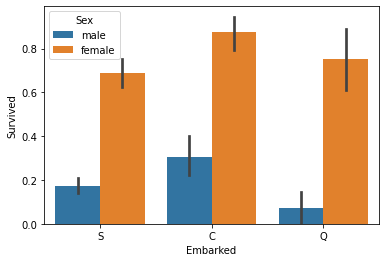

In [2]:
sns.barplot(x="Embarked", y="Survived", hue="Sex", data=data_train)
plt.show()

In [3]:
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df    
    
def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

data_train = transform_features(data_train)
data_test = transform_features(data_test)

In [6]:
from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ['Fare','Cabin','Age','Sex','Lname','NamePrefix']
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test

data_train, data_test = encode_features(data_train, data_test)

In [7]:
from sklearn.model_selection import train_test_split

X_all = data_train.drop(['Survived', 'PassengerId'], axis=1)
y_all = data_train['Survived']

num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=23)

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

# Choose the type of classifier. 
clf = RandomForestClassifier()

parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }
acc_scorer = make_scorer(accuracy_score)

grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

clf = grid_obj.best_estimator_

clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=5,
                       n_estimators=4)

In [9]:
predictions = clf.predict(X_test)

In [10]:
print(accuracy_score(y_test, predictions))

0.8044692737430168


In [14]:
from sklearn.model_selection import KFold
# from sklearn.cross_validation import KFold

# def run_kfold(clf):
#     kf = KFold(891, n_folds=10)
#     outcomes = []
#     fold = 0
#     for train_index, test_index in kf:
#         fold += 1
#         X_train, X_test = X_all.values[train_index], X_all.values[test_index]
#         y_train, y_test = y_all.values[train_index], y_all.values[test_index]
#         clf.fit(X_train, y_train)
#         predictions = clf.predict(X_test)
#         accuracy = accuracy_score(y_test, predictions)
#         outcomes.append(accuracy)
#         print("Fold {0} accuracy: {1}".format(fold, accuracy))     
#     mean_outcome = np.mean(outcomes)
#     print("Mean Accuracy: {0}".format(mean_outcome)) 

# run_kfold(clf)

In [24]:
from sklearn.model_selection import KFold

def run_kfold(clf):
    kf = KFold(n_splits=3, shuffle=False, random_state=1)
    outcomes = []
    fold = 0
    for train_index, test_index in kf.split(titanic[predictions]):
        fold += 1
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 

run_kfold(clf)

ValueError: Setting a random_state has no effect since shuffle is False. You should leave random_state to its default (None), or set shuffle=True.